# Enhanced Model with New Features

## Importing the libraries

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

## Importing the dataset

In [2]:
# Load Titanic data
df = pd.read_csv('/content/train.csv')

# Drop rows where 'Embarked' is missing (only 2 rows)
df = df.dropna(subset=['Embarked'])


##Model to predict the missing data for age (+20% of the rows) depending of the other variables

In [3]:
# Features to help predict Age
features_for_age = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Create a temporary DataFrame with one-hot encoding
df_temp = pd.get_dummies(df[features_for_age + ['Age']], drop_first=True)

# Split into known and missing Age
df_age_known = df_temp[df_temp['Age'].notnull()]
df_age_missing = df_temp[df_temp['Age'].isnull()]

# Train the model
X_age = df_age_known.drop('Age', axis=1)
y_age = df_age_known['Age']

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_age, y_age)

# Predict missing ages
X_missing_age = df_age_missing.drop('Age', axis=1)
predicted_ages = rfr.predict(X_missing_age)

# Fill back into the original DataFrame
df.loc[df['Age'].isnull(), 'Age'] = predicted_ages

##New feature "Title" with the "Name"




In [4]:
# Extract title
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                   'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                   'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

print(df['Title'].value_counts())


Title
Mr        517
Miss      184
Mrs       125
Master     40
Rare       23
Name: count, dtype: int64


##New feature "FamilySize" and "IsAlone"


In [5]:
# Create FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create IsAlone
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# print(df[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].head())


## New features: "FareBin" and "AgeBin"

Since these features are derived from "Fare" and "Age", they are naturally correlated. To avoid potential redundancy or bias in the model, I will test both options:
- One version using the original "Fare" and "Age"
- Another version using the binned features "FareBin" and "AgeBin"

I will keep the version that gives the best accuracy.

- Best Accuracy without theses features : **Test accuracy for DecisionTree: 0.8202**
- Best Accuracy with theses features(without Age and Fare) : **Test accuracy for XGBoost: 0.7921**
- Best Accuracy with all the features : **Test accuracy for GradientBoosting: 0.8202**

Then we can keep all the features but the Accuracy stay the same.

In [6]:
# AgeBand: split into 5 roughly equal-sized bins
df['AgeBand'] = pd.cut(df['Age'], 5)

# Create AgeBin (numeric version for modeling)
df['AgeBin'] = pd.cut(df['Age'], 5, labels=[0, 1, 2, 3, 4]).astype(int)

# FareBand: split into 4 quantile-based bins
df['FareBand'] = pd.qcut(df['Fare'], 4)

# Create FareBin (numeric version for modeling)
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)

# print(df[['Age', 'AgeBand', 'AgeBin', 'Fare', 'FareBand', 'FareBin']].head())


## Preprocessing pipeline

In [7]:
# Define features and target
X = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', "IsAlone", "FamilySize", "FareBin", "AgeBin", "Age", "Fare"]] #"Cabin" has too many NA values to be used
y = df['Survived']

# Column groups
numeric_features = ['SibSp', 'Parch', "FamilySize", "Age", "Fare"]
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', "IsAlone", "FareBin", "AgeBin" ]

# Pipelines
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Apply transformations
X_prepro = preprocessor.fit_transform(X)

# Get column names
num_cols = numeric_features
cat_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_columns = list(num_cols) + list(cat_cols)

# Wrap in DataFrame
X_final = pd.DataFrame(X_prepro, columns=all_columns)

# Optional: display the result
print(X_final.head())


      SibSp     Parch  FamilySize       Age      Fare  Pclass_1  Pclass_2  \
0  0.431350 -0.474326    0.057853 -0.545560 -0.500240       0.0       0.0   
1  0.431350 -0.474326    0.057853  0.619174  0.788947       1.0       0.0   
2 -0.475199 -0.474326   -0.561804 -0.254377 -0.486650       0.0       0.0   
3  0.431350 -0.474326    0.057853  0.400786  0.422861       1.0       0.0   
4 -0.475199 -0.474326   -0.561804  0.400786 -0.484133       0.0       0.0   

   Pclass_3  Sex_female  Sex_male  ...  IsAlone_1  FareBin_0  FareBin_1  \
0       1.0         0.0       1.0  ...        0.0        1.0        0.0   
1       0.0         1.0       0.0  ...        0.0        0.0        0.0   
2       1.0         1.0       0.0  ...        1.0        0.0        1.0   
3       0.0         1.0       0.0  ...        0.0        0.0        0.0   
4       1.0         0.0       1.0  ...        1.0        0.0        1.0   

   FareBin_2  FareBin_3  AgeBin_0  AgeBin_1  AgeBin_2  AgeBin_3  AgeBin_4  
0        0

##Import the models

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

##Define models and their hyperparameters

In [9]:
model_params = {
    'SVC': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.05, 0.1]
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=500, random_state=42),
        'params': {
            'model__hidden_layer_sizes': [(100,), (50, 50)],
            'model__alpha': [0.0001, 0.001]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': [None, 5, 10],
            'model__criterion': ['gini', 'entropy']
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'Voting': {
        'model': VotingClassifier(
            estimators=[
                ('svc', SVC(probability=True, random_state=42)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
                ('mlp', MLPClassifier(max_iter=500, random_state=42))
            ],
            voting='soft'
        ),
        'params': {}  # No hyperparameters to tune here directly
    }
}

## Split the data

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Loop on all the models to find the best parameters with a cross validation

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

best_models = {}

for name, mp in model_params.items():
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('model', mp['model'])
    ])

    clf = GridSearchCV(pipe, mp['params'], cv=5, n_jobs=-1, scoring='accuracy')
    clf.fit(X_train, y_train)

    print(f"Best parameters for {name}: {clf.best_params_}")
    print(f"Validation Accuracy for {name}: {clf.best_score_:.4f}")

    best_models[name] = clf.best_estimator_

Best parameters for SVC: {'model__C': 10, 'model__kernel': 'rbf'}
Validation Accuracy for SVC: 0.8368
Best parameters for RandomForest: {'model__max_depth': 10, 'model__n_estimators': 200}
Validation Accuracy for RandomForest: 0.8425
Best parameters for XGBoost: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100}
Validation Accuracy for XGBoost: 0.8383
Best parameters for MLP: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100,)}
Validation Accuracy for MLP: 0.8383
Best parameters for KNN: {'model__n_neighbors': 7, 'model__weights': 'uniform'}
Validation Accuracy for KNN: 0.8270
Best parameters for DecisionTree: {'model__criterion': 'entropy', 'model__max_depth': 5}
Validation Accuracy for DecisionTree: 0.8144
Best parameters for ExtraTrees: {'model__max_depth': 5, 'model__n_estimators': 100}
Validation Accuracy for ExtraTrees: 0.8326
Best parameters for GradientBoosting: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 1

## Display accuracy with the best parameters for each model

In [12]:
from sklearn.metrics import accuracy_score

# Optionally test on hold-out set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for {name}: {acc:.4f}")

Test accuracy for SVC: 0.7865
Test accuracy for RandomForest: 0.7697
Test accuracy for XGBoost: 0.8034
Test accuracy for MLP: 0.7753
Test accuracy for KNN: 0.7978
Test accuracy for DecisionTree: 0.8202
Test accuracy for ExtraTrees: 0.8034
Test accuracy for GradientBoosting: 0.8202
Test accuracy for Voting: 0.8146


## ✅ Feature Evaluation Summary

The features `FareBin` and `AgeBin` are derived from `Fare` and `Age`, so they are naturally correlated.  
To avoid potential redundancy or bias in the model, I tested **three configurations**:

- 🔹 **Version 1 – Baseline**: Without `Fare`, `Age`, `FareBin`, and `AgeBin`
- 🔹 **Version 2 – Binned Only**: All features included **except** `Fare` and `Age` (to avoid correlation)
- 🔹 **Version 3 – All Features**: Including both original and binned versions of `Fare` and `Age`

---

### 📊 Accuracy Comparison

#### 🔹 Version 1 – No Fare / Age / Binned

| Model              | Test Accuracy |
|-------------------|----------------|
| SVC               | 0.7921         |
| RandomForest      | 0.7978         |
| XGBoost           | 0.7921         |
| MLP               | 0.8034         |
| KNN               | 0.7640         |
| DecisionTree      | 0.7865         |
| ExtraTrees        | 0.7978         |
| GradientBoosting  | 0.7978         |
| **VotingClassifier** | **0.8202**     |

#### 🔹 Version 2 – Binned Features Only (No `Fare` and `Age`)

- ✅ Best Accuracy: **XGBoost – 0.7921**

#### 🔹 Version 3 – All Features (Original + Binned)

| Model              | Test Accuracy |
|-------------------|----------------|
| SVC               | 0.7865         |
| RandomForest      | 0.7697         |
| XGBoost           | 0.8034         |
| MLP               | 0.7753         |
| KNN               | 0.7978         |
| DecisionTree      | **0.8202**     |
| ExtraTrees        | 0.8034         |
| GradientBoosting  | **0.8202**     |
| VotingClassifier  | 0.8146         |

---

### ✅ Final Decision

- Best result **without** Fare/Age/Binned: `VotingClassifier – 0.8202`
- Best result **with binned only (no Fare/Age)**: `XGBoost – 0.7921`
- Best result **with all features**: `GradientBoosting / DecisionTree – 0.8202`

Since the highest accuracy is achieved **both with and without** the binned features, I will continue using **all features** for better model flexibility and feature richness.

---

## 🧪 Next Step: Apply PCA  
Now that the best baseline has been established using **all features**, I will apply **Principal Component Analysis (PCA)** to explore potential improvements in performance through dimensionality reduction.


## Resume of all the models with a graph

,Baseline,Binned Only,All Features,PCA
GradientBoosting,0.7978,NaN,0.8202,0.7640
DecisionTree,0.7865,NaN,0.8202,0.7978
Voting,0.8202,NaN,0.8146,0.7978
ExtraTrees,0.7978,NaN,0.8034,0.7697
XGBoost,0.7921,0.7921,0.8034,0.7753
KNN,0.7640,NaN,0.7978,0.7921
SVC,0.7921,NaN,0.7865,0.7921
MLP,0.8034,NaN,0.7753,0.8146
RandomForest,0.7978,NaN,0.7697,0.7697


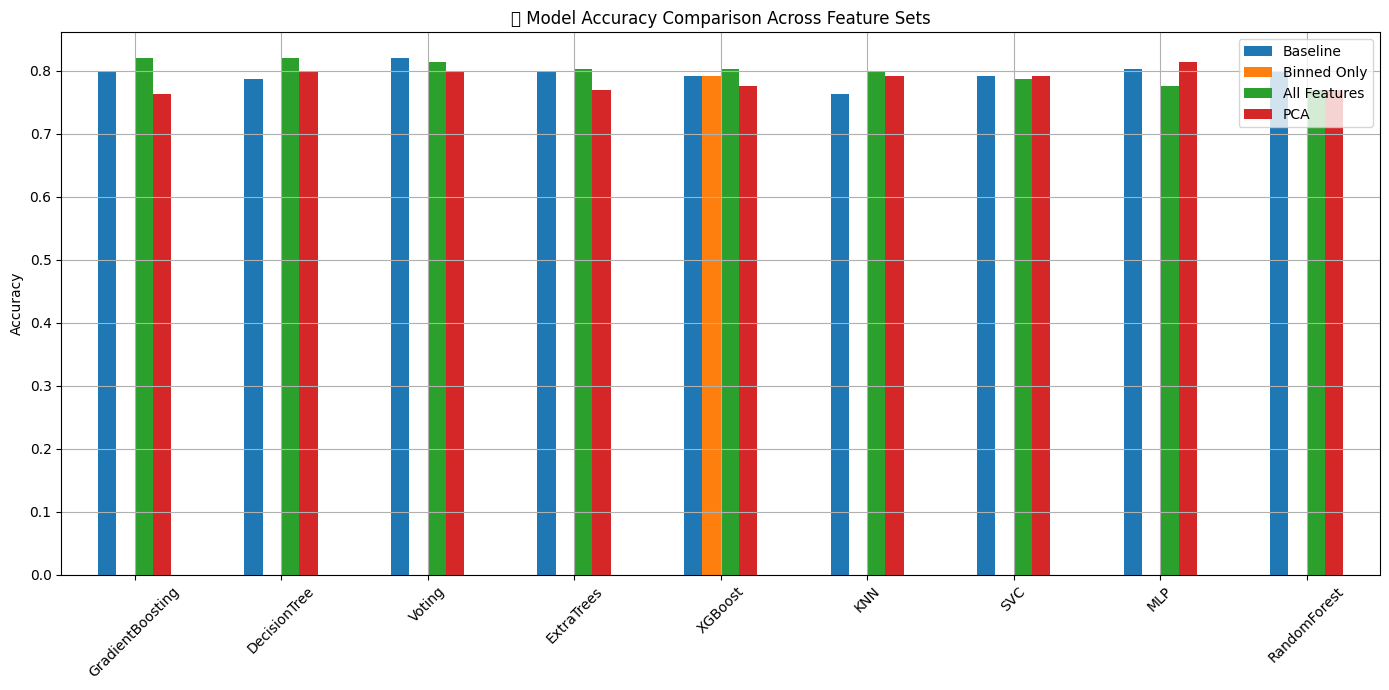

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Accuracy results
model_results = {
    'Baseline': {
        'SVC': 0.7921,
        'RandomForest': 0.7978,
        'XGBoost': 0.7921,
        'MLP': 0.8034,
        'KNN': 0.7640,
        'DecisionTree': 0.7865,
        'ExtraTrees': 0.7978,
        'GradientBoosting': 0.7978,
        'Voting': 0.8202
    },
    'Binned Only': {
        'XGBoost': 0.7921    #only the best has been kept
    },
    'All Features': {
        'SVC': 0.7865,
        'RandomForest': 0.7697,
        'XGBoost': 0.8034,
        'MLP': 0.7753,
        'KNN': 0.7978,
        'DecisionTree': 0.8202,
        'ExtraTrees': 0.8034,
        'GradientBoosting': 0.8202,
        'Voting': 0.8146
    },
    'PCA': {
        'SVC': 0.7921,
        'RandomForest': 0.7697,
        'XGBoost': 0.7753,
        'MLP': 0.8146,
        'KNN': 0.7921,
        'DecisionTree': 0.7978,
        'ExtraTrees': 0.7697,
        'GradientBoosting': 0.7640,
        'Voting': 0.7978
    }
}

# Convert to DataFrame
df_results = pd.DataFrame(model_results)

# Optional: sort rows by highest score in "All Features"
df_results = df_results.sort_values(by='All Features', ascending=False)

# Display table
display(df_results)

# Plot
df_results.plot(kind='bar', figsize=(14, 7))
plt.title('📊 Model Accuracy Comparison Across Feature Sets')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


##Visualize feature importances

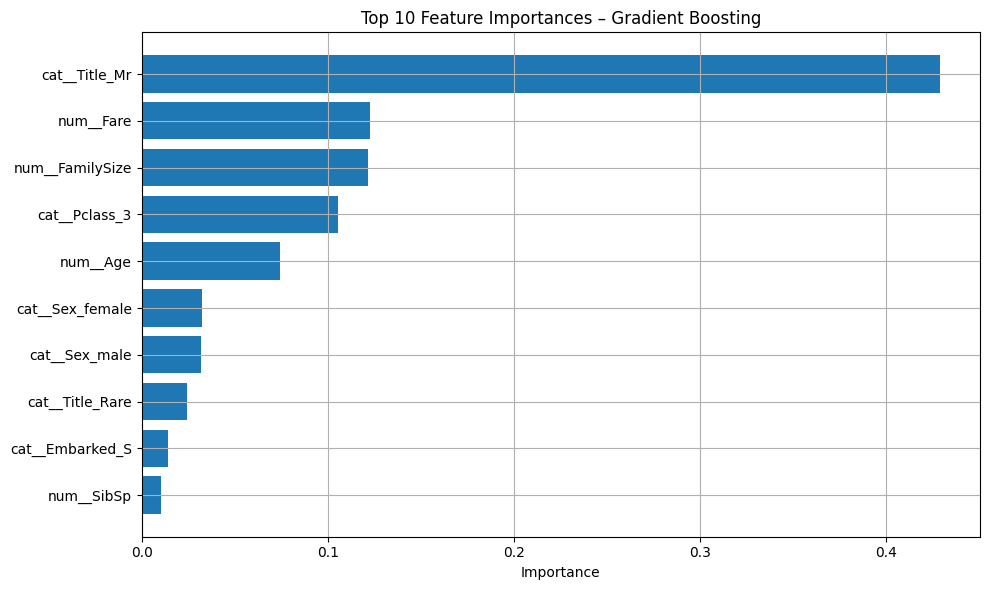

In [14]:
# Extract the trained Gradient Boosting model
gbc_model = best_models['GradientBoosting'].named_steps['model']

# Get feature names after preprocessing
feature_names = best_models['GradientBoosting'].named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = gbc_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], feature_importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances – Gradient Boosting')
plt.grid(True)
plt.tight_layout()
plt.show()


###Using the Gradient Boosting Classifier, we observe that the title "Mr" is by far the most influential feature, contributing to over 40% of the model's predictive power. Fare and FamilySize follow, each accounting for just over 10%, while Pclass_3 also plays a role, though to a slightly lesser extent. This highlights the strong impact of passenger title and socio-economic indicators on survival predictions.

# Result data for Kaggle

###Using the trained Gradient Boosting Classifier, we applied our pipeline to a new dataset without survival labels. The model outputs a prediction (0 = did not survive, 1 = survived) based on the learned patterns from the original Titanic dataset. This process ensures consistency in feature processing and model inference.



In [15]:
# Load the new dataset (same structure as train.csv but without 'Survived')
df = pd.read_csv('/content/test.csv')  # Replace with your actual file name

In [16]:

# Drop rows where 'Embarked' is missing
df = df.dropna(subset=['Embarked'])
fare_median = df['Fare'].median()

# Fill missing Fare values
df['Fare'].fillna(fare_median, inplace=True)

df.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,327


##Model to predict the missing data for age (+20% of the rows) depending of the other variables

In [17]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Features to help predict Age
features_for_age = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Drop rows with missing values in any of the relevant features (EXCEPT Age)
df_age_input = df[features_for_age + ['Age']].copy()
df_age_input = df_age_input.dropna(subset=features_for_age)

# One-hot encode
df_temp = pd.get_dummies(df_age_input, drop_first=True)

# Split
df_age_known = df_temp[df_temp['Age'].notnull()]
df_age_missing = df_temp[df_temp['Age'].isnull()]

# Check before proceeding
if df_age_missing.empty:
    print("❗No rows with missing Age available to predict.")
else:
    # Train
    X_age = df_age_known.drop('Age', axis=1)
    y_age = df_age_known['Age']
    rfr = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr.fit(X_age, y_age)

    # Predict
    X_missing_age = df_age_missing.drop('Age', axis=1)
    predicted_ages = rfr.predict(X_missing_age)

    # Align indices to safely assign
    df.loc[df_age_missing.index, 'Age'] = predicted_ages


##New feature "Title" with the "Name"




In [18]:
# Extract title
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                   'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                   'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

print(df['Title'].value_counts())


Title
Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: count, dtype: int64


##New feature "FamilySize" and "IsAlone"


In [19]:
# Create FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create IsAlone
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

print(df[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].head())


   SibSp  Parch  FamilySize  IsAlone
0      0      0           1        1
1      1      0           2        0
2      0      0           1        1
3      0      0           1        1
4      1      1           3        0


In [20]:
# AgeBand: split into 5 roughly equal-sized bins
df['AgeBand'] = pd.cut(df['Age'], 5)

# Create AgeBin (numeric version for modeling)
df['AgeBin'] = pd.cut(df['Age'], 5, labels=[0, 1, 2, 3, 4]).astype(int)

# FareBand: split into 4 quantile-based bins
df['FareBand'] = pd.qcut(df['Fare'], 4)

# Create FareBin (numeric version for modeling)
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)

# print(df[['Age', 'AgeBand', 'AgeBin', 'Fare', 'FareBand', 'FareBin']].head())


## Preprocessing pipeline

In [21]:
# Define features and target
X = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', "IsAlone", "FamilySize", "FareBin", "AgeBin", "Age", "Fare"]] #"Cabin" has too many NA values to be used

# Column groups
numeric_features = ['SibSp', 'Parch', "FamilySize", "Age", "Fare"]
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', "IsAlone", "FareBin", "AgeBin" ]

# Pipelines
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Apply transformations
X_prepro = preprocessor.fit_transform(X)

# Get column names
num_cols = numeric_features
cat_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_columns = list(num_cols) + list(cat_cols)

# Wrap in DataFrame
X_final = pd.DataFrame(X_prepro, columns=all_columns)

# Optional: display the result
print(X_final.head())


      SibSp     Parch  FamilySize       Age      Fare  Pclass_1  Pclass_2  \
0 -0.499470 -0.400248   -0.553443  0.360388 -0.497413       0.0       0.0   
1  0.616992 -0.400248    0.105643  1.317902 -0.512278       0.0       0.0   
2 -0.499470 -0.400248   -0.553443  2.466919 -0.464100       0.0       1.0   
3 -0.499470 -0.400248   -0.553443 -0.214120 -0.482475       0.0       0.0   
4  0.616992  0.619896    0.764728 -0.597126 -0.417492       0.0       0.0   

   Pclass_3  Sex_female  Sex_male  ...  IsAlone_1  FareBin_0  FareBin_1  \
0       1.0         0.0       1.0  ...        1.0        1.0        0.0   
1       1.0         1.0       0.0  ...        0.0        1.0        0.0   
2       0.0         0.0       1.0  ...        1.0        0.0        1.0   
3       1.0         0.0       1.0  ...        1.0        0.0        1.0   
4       1.0         1.0       0.0  ...        0.0        0.0        1.0   

   FareBin_2  FareBin_3  AgeBin_0  AgeBin_1  AgeBin_2  AgeBin_3  AgeBin_4  
0        0

In [24]:

final_model = best_models['GradientBoosting']  # Because it was the best model

# Make predictions directly
predictions = final_model.predict(df)

# Export submission file
submission = pd.DataFrame({
    'PassengerId': df['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)